In [172]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy import hstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
from matplotlib import pyplot
import zipfile
from PIL import Image
from numpy.random import random
from numpy.random import choice

from math import sqrt
from numpy import asarray
from keras.models import load_model

class InfoGAN:
    def __init__(self):
        
        # number of values for the categorical control code
        self.n_cat = 10
        self.n_con=2
        # size of the latent space
        self.latent_dim = 62
        #Define size of generator input
        self.gen_input_size = self.latent_dim + self.n_cat +self.n_con
        self.batch_size=128
        self.kernel_init = RandomNormal(stddev=0.02)

    
         
    def load_MNIST(self):
        ds, ds_info = tfds.load('mnist', split='train', with_info=True,as_supervised=True,batch_size=-1)
        shape=ds_info.features['image'].shape
        (img_train, label_train)=tfds.as_numpy(ds)
        img_train=(img_train.astype('float32')-127.5)/127.5
        return img_train, shape
    
    def load_SVHN(self):
        ds, ds_info = tfds.load('svhn_cropped', split='train', with_info=True,as_supervised=True,batch_size=-1)
        shape=ds_info.features['image'].shape
        (img_train, label_train)=tfds.as_numpy(ds)
        img_train=img_train.astype('float32')/255
        return img_train,ds, ds_info, shape
    
    def load_CELEBA(self):
        imgzip = zipfile.ZipFile("img_align_celeba.zip")
        inflist = imgzip.infolist()
        img_train=[]
        for f in inflist[1:]:
            ifile = imgzip.open(f)
            img = Image.open(ifile)
            img=img.resize((32,32),resample=Image.LANCZOS)
            img_train.append(np.array(img))
        img_train=np.array(img_train)
        img_train=(img_train.astype('float32')-127.5)/127.5
        shape=(img_train.shape[1],img_train.shape[2],img_train.shape[3])
        return img_train,shape
        

    def show_real_examples(self,ds, ds_info):
        fig = tfds.show_examples(ds, ds_info)

    #Define the generator model:
    def get_generator(self,shape):
        input_latent = layers.Input(shape=(self.gen_input_size))
        
        #The various datasets have various sizes and #channels so the dimension of the generator needs to be variable
        res=int(shape[0]/4)
        depth=int(shape[-1])
        
        n_nodes =256*7*7
        g = layers.Dense(n_nodes)(input_latent)
        g = layers.BatchNormalization()(g)
        g = layers.ReLU()(g)

        g = layers.Reshape((7, 7, 256))(g)
        
        g = layers.Conv2D(128, 4, padding='same',kernel_initializer=self.kernel_init)(g)
        g = layers.BatchNormalization()(g)
        g = layers.ReLU()(g)
        
        g = layers.Conv2DTranspose(64, 4,strides=(2,2), padding='same',kernel_initializer=self.kernel_init)(g)
        g = layers.BatchNormalization()(g)
        g = layers.ReLU()(g)

        g = layers.Conv2DTranspose(depth, 4, strides=(2,2), padding='same',kernel_initializer=self.kernel_init)(g)
        # Tanh output
        output_layer = layers.Activation('tanh')(g)
        # define the generator model
        gen_model = Model(input_latent, output_layer)
        return gen_model
    
    
    def get_discr_q(self,input_shape):
        input_image=layers.Input(shape=input_shape)

        l=layers.Conv2D(128, 4, strides=(2,2),padding='same',kernel_initializer=self.kernel_init)(input_image)
        l=layers.BatchNormalization()(l)
        l=layers.LeakyReLU(alpha=0.2)(l)
        
        l=layers.Conv2D(256, 4, strides=(2,2), padding='same',kernel_initializer=self.kernel_init)(l)
        l=layers.BatchNormalization()(l)
        l=layers.LeakyReLU(alpha=0.2)(l)
        
        l=layers.Conv2D(512, 4, strides=(2,2), padding='same',kernel_initializer=self.kernel_init)(l)
        l=layers.BatchNormalization()(l)
        l=layers.LeakyReLU(alpha=0.2)(l)
     
    
        l=layers.Flatten()(l)
        
        #Classification head of the discriminator
        out=layers.Dense(1,activation='sigmoid')(l)
        discr_model = Model(input_image, out)
        discr_model.compile(loss='binary_crossentropy',metrics='accuracy', optimizer=Adam(lr=2e-4, beta_1=0.5))
        # create q model layers
        q = layers.Dense(128)(l)
        q = layers.BatchNormalization()(q)
        q = layers.LeakyReLU(alpha=0.2)(q)
        # q model output
        out_codes_discrete = layers.Dense(self.n_cat, activation='softmax')(q)
        out_codes_continuous=layers.Dense(self.n_con,activation='linear') (q)
        #out
        # define q model
        q_model = Model(input_image, [out_codes_discrete,out_codes_continuous])
        return discr_model, q_model
    

    def infogan(self,gen_model, discr_model, q_model):
        # make weights in the discriminator (some shared with the q model) as not trainable
        for layer in discr_model.layers:
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = False
        # connect g outputs to d inputs
        discr_output = discr_model(gen_model.output)
        # connect g outputs to q inputs
        q_output = q_model(gen_model.output)
        # define composite model
        infogan_model = Model(gen_model.input, [discr_output]+q_output)
        # compile model
        opt = Adam(lr=2e-4, beta_1=0.5)
        infogan_model.compile(loss=['binary_crossentropy', 'categorical_crossentropy','mse'], optimizer=opt)
        return infogan_model
    
    def smooth_positive_labels(self,y):
        return y - 0.1 + (random(y.shape) * 0.2)


    def noisy_labels(self,y, p_flip):
        # determine the number of labels to flip
        n_select = int(p_flip * y.shape[0])
        # choose labels to flip
        flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
        # invert the labels in place
        y[flip_ix] = 1 - y[flip_ix]
        return y
    
    # select real samples
    def generate_real_samples(self,dataset, n_samples):
        # choose random instances
        ix = randint(0, dataset.shape[0], n_samples)
        # select images and labels
        X = dataset[ix]
        # generate class labels
        y = ones((n_samples, 1))
        #y=self.smooth_positive_labels(y)
        #y=self.noisy_labels(y,0.05)
        return X, y
    
    # generate points in latent space as input for the generator
    # generate points in latent space as input for the generator
    def generate_noise(self, n_samples):
        # generate points in the latent space
        z_latent=randn(n_samples,self.latent_dim)
        # generate categorical one-hot codes
        cat_codes=np.eye(self.n_cat)[np.random.choice(self.n_cat, n_samples)]
        # concatenate latent points and control codes
        # generate continuous codes
        con_codes = randn(self.n_con * n_samples)
        # reshape continuous codes
        con_codes = con_codes.reshape(n_samples, self.n_con)
        z_input = hstack((z_latent, cat_codes,con_codes))
        return [z_input, cat_codes,con_codes]
    
    # use the generator to generate n fake examples, with class labels
    def generate_fake_samples(self,generator, n_samples):
        # generate points in latent space and control codes
        z_input, _, _ = self.generate_noise(n_samples)
        # predict outputs
        images = generator.predict(z_input)
        # create class labels
        y = zeros((n_samples, 1))
        #y=self.noisy_labels(y,0.05)
        return images, y
    
    def summarize_performance(self,step, gen_model, gan_model, n_samples=100):
        # prepare fake examples
        pyplot.rcParams["figure.figsize"] = (20,10)
        X, _ = self.generate_fake_samples(gen_model, n_samples)
        X = (X + 1) / 2.0
        # plot images
        for i in range(n_samples):
            # define subplot
            pyplot.subplot(10, 10, 1 + i)
            # turn off axis
            pyplot.axis('off')
            # plot raw pixel data
            if X.shape[-1]==1:
              pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
            else:
              pyplot.imshow(X[i, :, :, :])
        # save plot to file
        filename1 = 'images_mnist/generated_plot_%04d.png' % (step+1)
        pyplot.savefig(filename1)
        pyplot.close()
        # save the generator model
        filename2 = 'images_mnist/model_%04d.h5' % (step+1)
        gen_model.save(filename2)
        # save the gan model
        filename3 = 'images_mnist/gan_model_%04d.h5' % (step+1)
        gan_model.save(filename3)
        print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))
        
    # train the generator and discriminator
    def train(self,gen_model, discr_model, infogan_model, dataset, n_epochs=100):
        # calculate the number of batches per training epoch
        bat_per_epo = int(len(dataset)/self.batch_size)
        print("Batch per epoch: ",bat_per_epo)
        # calculate the number of training iterations
        n_steps = int(bat_per_epo * n_epochs)
        print("N_Steps:",n_steps)
        saved_metrics={'d_loss1':[],'d_loss2':[],'g_1':[],'g_2':[], 'g_3':[]}
        # manually enumerate epochs
        for i in range(n_steps):
            X_real, y_real = self.generate_real_samples(dataset, int(self.batch_size/2))
            # update discriminator and q model weights
            d_loss1 = discr_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = self.generate_fake_samples(gen_model, int(self.batch_size/2))
            # update discriminator model weights
            d_loss2 = discr_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            z_input, cat_codes, con_codes = self.generate_noise(self.batch_size)
            # create inverted labels for the fake samples
            y_gan = ones((self.batch_size, 1))
            # update the g via the d and q error
            _,g_1,g_2, g_3  = infogan_model.train_on_batch(z_input, [y_gan, cat_codes, con_codes])
            saved_metrics['d_loss1'].append(d_loss1[0])
            saved_metrics['d_loss2'].append(d_loss2[0])
            saved_metrics['g_1'].append(g_1)
            saved_metrics['g_2'].append(g_2)
            saved_metrics['g_3'].append(g_3)
            # summarize loss on this batch
            if(i+1)%100==0:
                print('>%d, d[%.3f,%.3f],acc[%.3f,%.3f], g[%.3f] q[%.3f, %.3f ]' % (i+1, d_loss1[0], d_loss2[0],d_loss1[1], d_loss2[1], g_1, g_2, g_3 ))
            # evaluate the model performance every 'epoch'
            if (i+1) % (bat_per_epo * 10) == 0:
                self.summarize_performance(i, gen_model, infogan_model)
                pyplot.plot(saved_metrics['g_1'], 'r',label='gen')  
                pyplot.plot(saved_metrics['d_loss1'], 'b',label='disc_real') 
                pyplot.plot(saved_metrics['d_loss2'] ,'g',label='disc_fake') 
                pyplot.plot(saved_metrics['g_2'],'y',label='q_discrete')
                pyplot.plot(saved_metrics['g_3'],'y',label='q_cont')

                pyplot.legend() 
                pyplot.grid()
                pyplot.title('Learning curves of GAN')
                pyplot.savefig('images_mnist/learning_curves_{}'.format(i))
                pyplot.close()

In [173]:
gan=InfoGAN()
img_train,shape=gan.load_MNIST()
gen_model=gan.get_generator(shape)
discr_model,q_model=gan.get_discr_q(shape)
infogan_model=gan.infogan(gen_model, discr_model, q_model)

In [174]:
discr_model.summary()

Model: "model_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 14, 14, 128)       2176      
_________________________________________________________________
batch_normalization_195 (Bat (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_134 (LeakyReLU)  (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 7, 7, 256)         524544    
_________________________________________________________________
batch_normalization_196 (Bat (None, 7, 7, 256)         1024      
_________________________________________________________________
leaky_re_lu_135 (LeakyReLU)  (None, 7, 7, 256)         0 

In [175]:
gan.train(gen_model, discr_model, infogan_model, img_train, n_epochs=100)

Batch per epoch:  468
N_Steps: 46800
>100, d[0.000,0.000],acc[1.000,1.000], g[0.001] q[0.101, 0.150 ]
>200, d[0.000,0.000],acc[1.000,1.000], g[0.001] q[0.026, 0.076 ]
>300, d[0.000,0.000],acc[1.000,1.000], g[0.004] q[0.015, 0.061 ]
>400, d[0.011,0.016],acc[1.000,1.000], g[1.954] q[0.029, 0.130 ]
>500, d[0.001,0.001],acc[1.000,1.000], g[0.045] q[0.026, 0.085 ]
>600, d[0.079,0.053],acc[1.000,1.000], g[1.143] q[0.065, 0.084 ]
>700, d[0.069,0.092],acc[1.000,1.000], g[2.195] q[0.048, 0.104 ]
>800, d[0.333,0.465],acc[0.906,0.797], g[3.151] q[0.053, 0.150 ]
>900, d[0.042,0.084],acc[1.000,1.000], g[2.563] q[0.056, 0.133 ]
>1000, d[0.092,0.056],acc[1.000,1.000], g[1.035] q[0.058, 0.151 ]
>1100, d[0.094,0.261],acc[0.984,0.938], g[3.849] q[0.079, 0.135 ]
>1200, d[0.257,0.263],acc[0.953,0.922], g[2.954] q[0.044, 0.155 ]
>1300, d[0.148,0.106],acc[0.969,1.000], g[2.348] q[0.042, 0.140 ]
>1400, d[0.047,0.242],acc[1.000,0.953], g[2.989] q[0.056, 0.161 ]
>1500, d[0.277,0.140],acc[0.891,0.984], g[1.651]

>Saved: images_mnist/generated_plot_4680.png, images_mnist/model_4680.h5, and images_mnist/gan_model_4680.h5
>4700, d[0.453,0.429],acc[0.812,0.859], g[1.781] q[0.015, 0.077 ]
>4800, d[0.418,0.422],acc[0.859,0.812], g[1.644] q[0.026, 0.085 ]
>4900, d[0.461,0.398],acc[0.844,0.859], g[1.460] q[0.031, 0.074 ]
>5000, d[0.448,0.450],acc[0.828,0.844], g[1.493] q[0.009, 0.074 ]
>5100, d[0.674,0.556],acc[0.641,0.672], g[1.170] q[0.021, 0.080 ]
>5200, d[0.452,0.507],acc[0.875,0.812], g[1.574] q[0.023, 0.079 ]
>5300, d[0.585,0.493],acc[0.703,0.812], g[1.546] q[0.028, 0.069 ]
>5400, d[0.562,0.455],acc[0.719,0.812], g[1.326] q[0.025, 0.076 ]
>5500, d[0.606,0.562],acc[0.672,0.703], g[1.392] q[0.033, 0.074 ]
>5600, d[0.555,0.604],acc[0.719,0.672], g[1.345] q[0.036, 0.079 ]
>5700, d[0.499,0.551],acc[0.781,0.703], g[1.413] q[0.008, 0.085 ]
>5800, d[0.551,0.633],acc[0.734,0.672], g[1.226] q[0.013, 0.064 ]
>5900, d[0.571,0.705],acc[0.719,0.531], g[1.423] q[0.058, 0.065 ]
>6000, d[0.599,0.557],acc[0.703,0

>Saved: images_mnist/generated_plot_9360.png, images_mnist/model_9360.h5, and images_mnist/gan_model_9360.h5
>9400, d[0.689,0.733],acc[0.531,0.422], g[0.852] q[0.009, 0.043 ]
>9500, d[0.682,0.775],acc[0.562,0.281], g[0.942] q[0.003, 0.047 ]
>9600, d[0.724,0.787],acc[0.469,0.297], g[0.947] q[0.019, 0.067 ]
>9700, d[0.709,0.718],acc[0.500,0.391], g[0.846] q[0.003, 0.045 ]
>9800, d[0.732,0.703],acc[0.438,0.484], g[0.855] q[0.003, 0.045 ]
>9900, d[0.696,0.725],acc[0.531,0.422], g[0.849] q[0.001, 0.045 ]
>10000, d[0.708,0.745],acc[0.531,0.359], g[0.865] q[0.051, 0.051 ]
>10100, d[0.695,0.717],acc[0.594,0.438], g[0.886] q[0.001, 0.035 ]
>10200, d[0.686,0.764],acc[0.578,0.344], g[0.834] q[0.028, 0.046 ]
>10300, d[0.733,0.711],acc[0.484,0.484], g[0.922] q[0.011, 0.050 ]
>10400, d[0.618,0.747],acc[0.734,0.438], g[0.843] q[0.010, 0.054 ]
>10500, d[0.653,0.727],acc[0.578,0.375], g[0.843] q[0.005, 0.033 ]
>10600, d[0.665,0.732],acc[0.609,0.438], g[0.852] q[0.035, 0.042 ]
>10700, d[0.713,0.724],acc

>Saved: images_mnist/generated_plot_14040.png, images_mnist/model_14040.h5, and images_mnist/gan_model_14040.h5
>14100, d[0.700,0.726],acc[0.484,0.375], g[0.744] q[0.001, 0.031 ]
>14200, d[0.710,0.752],acc[0.500,0.266], g[0.752] q[0.003, 0.045 ]
>14300, d[0.694,0.748],acc[0.594,0.266], g[0.741] q[0.024, 0.037 ]
>14400, d[0.705,0.710],acc[0.469,0.438], g[0.767] q[0.002, 0.033 ]
>14500, d[0.697,0.720],acc[0.469,0.438], g[0.800] q[0.004, 0.037 ]
>14600, d[0.705,0.741],acc[0.562,0.297], g[0.755] q[0.007, 0.028 ]
>14700, d[0.699,0.703],acc[0.516,0.406], g[0.745] q[0.001, 0.044 ]
>14800, d[0.693,0.726],acc[0.578,0.344], g[0.793] q[0.001, 0.056 ]
>14900, d[0.720,0.745],acc[0.344,0.281], g[0.743] q[0.002, 0.047 ]
>15000, d[0.719,0.726],acc[0.359,0.266], g[0.758] q[0.006, 0.038 ]
>15100, d[0.678,0.738],acc[0.672,0.250], g[0.758] q[0.002, 0.042 ]
>15200, d[0.705,0.713],acc[0.406,0.344], g[0.742] q[0.001, 0.032 ]
>15300, d[0.690,0.726],acc[0.594,0.375], g[0.765] q[0.001, 0.044 ]
>15400, d[0.688,0

>Saved: images_mnist/generated_plot_18720.png, images_mnist/model_18720.h5, and images_mnist/gan_model_18720.h5
>18800, d[0.710,0.726],acc[0.328,0.266], g[0.732] q[0.001, 0.051 ]
>18900, d[0.682,0.727],acc[0.594,0.219], g[0.724] q[0.002, 0.020 ]
>19000, d[0.699,0.728],acc[0.500,0.234], g[0.734] q[0.000, 0.027 ]
>19100, d[0.693,0.719],acc[0.469,0.281], g[0.733] q[0.008, 0.033 ]
>19200, d[0.695,0.721],acc[0.438,0.281], g[0.731] q[0.031, 0.031 ]
>19300, d[0.705,0.719],acc[0.375,0.281], g[0.727] q[0.001, 0.020 ]
>19400, d[0.702,0.721],acc[0.531,0.250], g[0.724] q[0.001, 0.022 ]
>19500, d[0.712,0.732],acc[0.391,0.281], g[0.726] q[0.004, 0.035 ]
>19600, d[0.715,0.713],acc[0.391,0.297], g[0.730] q[0.004, 0.042 ]
>19700, d[0.701,0.732],acc[0.469,0.234], g[0.730] q[0.000, 0.028 ]
>19800, d[0.700,0.735],acc[0.484,0.219], g[0.728] q[0.009, 0.029 ]
>19900, d[0.695,0.687],acc[0.438,0.656], g[0.749] q[0.026, 0.027 ]
>20000, d[0.692,0.710],acc[0.531,0.391], g[0.750] q[0.002, 0.029 ]
>20100, d[0.678,0

>Saved: images_mnist/generated_plot_23400.png, images_mnist/model_23400.h5, and images_mnist/gan_model_23400.h5
>23500, d[0.680,0.710],acc[0.656,0.359], g[0.738] q[0.001, 0.025 ]
>23600, d[0.677,0.710],acc[0.578,0.375], g[0.793] q[0.033, 0.049 ]
>23700, d[0.686,0.720],acc[0.531,0.266], g[0.716] q[0.000, 0.032 ]
>23800, d[0.684,0.688],acc[0.531,0.562], g[0.738] q[0.003, 0.038 ]
>23900, d[0.686,0.718],acc[0.547,0.266], g[0.713] q[0.003, 0.039 ]
>24000, d[0.671,0.723],acc[0.750,0.312], g[0.709] q[0.003, 0.025 ]
>24100, d[0.696,0.728],acc[0.500,0.266], g[0.727] q[0.000, 0.032 ]
>24200, d[0.681,0.736],acc[0.578,0.203], g[0.711] q[0.001, 0.023 ]
>24300, d[0.702,0.708],acc[0.422,0.438], g[0.731] q[0.004, 0.027 ]
>24400, d[0.707,0.706],acc[0.344,0.375], g[0.723] q[0.012, 0.050 ]
>24500, d[0.697,0.703],acc[0.438,0.438], g[0.788] q[0.005, 0.051 ]
>24600, d[0.673,0.708],acc[0.688,0.438], g[0.721] q[0.002, 0.035 ]
>24700, d[0.694,0.715],acc[0.500,0.359], g[0.721] q[0.002, 0.036 ]
>24800, d[0.696,0

>Saved: images_mnist/generated_plot_28080.png, images_mnist/model_28080.h5, and images_mnist/gan_model_28080.h5
>28100, d[0.688,0.722],acc[0.594,0.297], g[0.712] q[0.009, 0.030 ]
>28200, d[0.664,0.722],acc[0.703,0.328], g[0.698] q[0.001, 0.031 ]
>28300, d[0.680,0.712],acc[0.641,0.312], g[0.734] q[0.001, 0.030 ]
>28400, d[0.663,0.721],acc[0.703,0.297], g[0.699] q[0.001, 0.032 ]
>28500, d[0.691,0.715],acc[0.516,0.344], g[0.702] q[0.001, 0.025 ]
>28600, d[0.689,0.719],acc[0.562,0.344], g[0.713] q[0.001, 0.030 ]
>28700, d[0.669,0.710],acc[0.672,0.375], g[0.722] q[0.001, 0.028 ]
>28800, d[0.684,0.734],acc[0.625,0.234], g[0.716] q[0.003, 0.026 ]
>28900, d[0.693,0.726],acc[0.500,0.328], g[0.700] q[0.001, 0.033 ]
>29000, d[0.693,0.722],acc[0.594,0.297], g[0.717] q[0.000, 0.019 ]
>29100, d[0.661,0.696],acc[0.688,0.516], g[0.735] q[0.001, 0.028 ]
>29200, d[0.680,0.704],acc[0.578,0.406], g[0.732] q[0.003, 0.050 ]
>29300, d[0.681,0.708],acc[0.641,0.391], g[0.735] q[0.000, 0.030 ]
>29400, d[0.693,0

>Saved: images_mnist/generated_plot_32760.png, images_mnist/model_32760.h5, and images_mnist/gan_model_32760.h5
>32800, d[0.683,0.697],acc[0.594,0.516], g[0.708] q[0.000, 0.019 ]
>32900, d[0.701,0.698],acc[0.438,0.469], g[0.729] q[0.000, 0.028 ]
>33000, d[0.696,0.692],acc[0.500,0.484], g[0.725] q[0.001, 0.050 ]
>33100, d[0.691,0.727],acc[0.438,0.234], g[0.724] q[0.003, 0.029 ]
>33200, d[0.664,0.718],acc[0.719,0.406], g[0.712] q[0.003, 0.034 ]
>33300, d[0.680,0.708],acc[0.625,0.406], g[0.747] q[0.001, 0.032 ]
>33400, d[0.674,0.733],acc[0.641,0.234], g[0.711] q[0.000, 0.026 ]
>33500, d[0.687,0.716],acc[0.500,0.328], g[0.714] q[0.003, 0.019 ]
>33600, d[0.657,0.684],acc[0.797,0.531], g[0.706] q[0.001, 0.038 ]
>33700, d[0.673,0.669],acc[0.719,0.672], g[0.697] q[0.002, 0.021 ]
>33800, d[0.694,0.720],acc[0.500,0.297], g[0.716] q[0.000, 0.026 ]
>33900, d[0.704,0.699],acc[0.422,0.453], g[0.716] q[0.008, 0.024 ]
>34000, d[0.667,0.709],acc[0.734,0.359], g[0.721] q[0.001, 0.030 ]
>34100, d[0.690,0

>Saved: images_mnist/generated_plot_37440.png, images_mnist/model_37440.h5, and images_mnist/gan_model_37440.h5
>37500, d[0.670,0.713],acc[0.688,0.375], g[0.725] q[0.001, 0.044 ]
>37600, d[0.702,0.708],acc[0.531,0.484], g[0.738] q[0.000, 0.031 ]
>37700, d[0.694,0.697],acc[0.469,0.438], g[0.722] q[0.000, 0.024 ]
>37800, d[0.697,0.698],acc[0.469,0.484], g[0.718] q[0.001, 0.027 ]
>37900, d[0.691,0.707],acc[0.516,0.406], g[0.724] q[0.001, 0.018 ]
>38000, d[0.680,0.701],acc[0.594,0.484], g[0.724] q[0.004, 0.019 ]
>38100, d[0.680,0.697],acc[0.562,0.500], g[0.711] q[0.001, 0.025 ]
>38200, d[0.681,0.706],acc[0.531,0.375], g[0.721] q[0.002, 0.055 ]
>38300, d[0.702,0.713],acc[0.406,0.406], g[0.709] q[0.001, 0.026 ]
>38400, d[0.677,0.703],acc[0.625,0.344], g[0.722] q[0.001, 0.024 ]
>38500, d[0.690,0.709],acc[0.531,0.375], g[0.718] q[0.008, 0.027 ]
>38600, d[0.702,0.715],acc[0.391,0.281], g[0.716] q[0.001, 0.027 ]
>38700, d[0.674,0.700],acc[0.609,0.422], g[0.707] q[0.001, 0.034 ]
>38800, d[0.667,0

>Saved: images_mnist/generated_plot_42120.png, images_mnist/model_42120.h5, and images_mnist/gan_model_42120.h5
>42200, d[0.699,0.707],acc[0.453,0.391], g[0.712] q[0.019, 0.020 ]
>42300, d[0.681,0.699],acc[0.578,0.422], g[0.707] q[0.001, 0.023 ]
>42400, d[0.706,0.708],acc[0.391,0.328], g[0.708] q[0.001, 0.018 ]
>42500, d[0.681,0.696],acc[0.625,0.516], g[0.704] q[0.000, 0.032 ]
>42600, d[0.721,0.702],acc[0.281,0.453], g[0.716] q[0.000, 0.028 ]
>42700, d[0.697,0.680],acc[0.500,0.594], g[0.712] q[0.000, 0.037 ]
>42800, d[0.692,0.705],acc[0.438,0.359], g[0.731] q[0.000, 0.028 ]
>42900, d[0.694,0.704],acc[0.578,0.422], g[0.709] q[0.003, 0.015 ]
>43000, d[0.675,0.697],acc[0.703,0.484], g[0.697] q[0.000, 0.022 ]
>43100, d[0.694,0.710],acc[0.562,0.328], g[0.705] q[0.003, 0.034 ]
>43200, d[0.677,0.704],acc[0.594,0.344], g[0.715] q[0.001, 0.020 ]
>43300, d[0.674,0.701],acc[0.672,0.453], g[0.706] q[0.000, 0.026 ]
>43400, d[0.682,0.686],acc[0.656,0.500], g[0.715] q[0.000, 0.033 ]
>43500, d[0.681,0

>Saved: images_mnist/generated_plot_46800.png, images_mnist/model_46800.h5, and images_mnist/gan_model_46800.h5


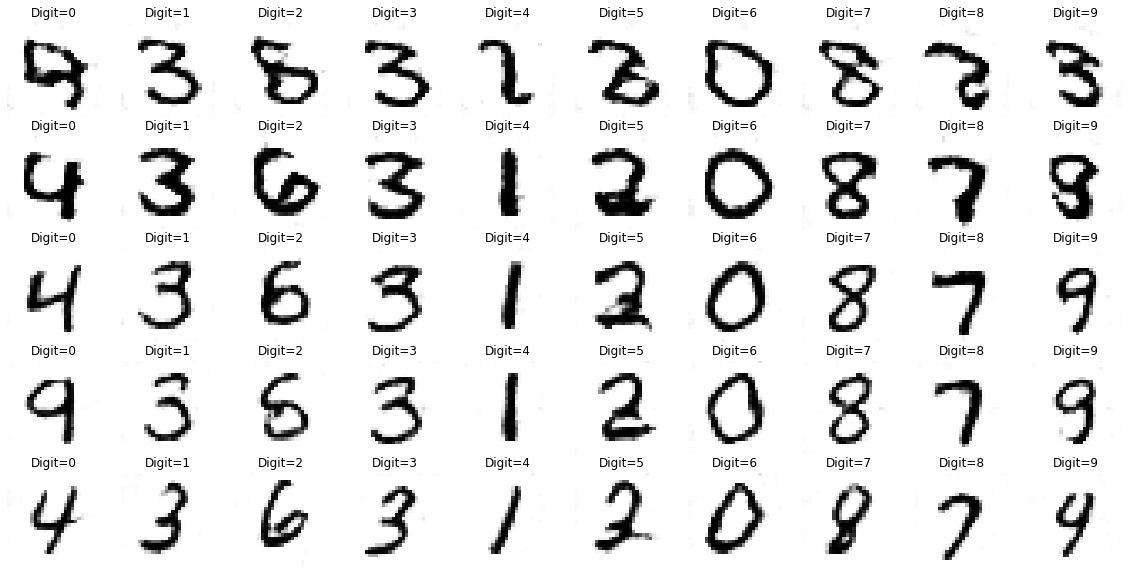

In [185]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_cat,n_con, n_samples, digit):
# generate points in the latent space
    z_latent=randn(n_samples,latent_dim)
    # generate categorical one-hot codes
    cat_codes=np.eye(n_cat)[np.random.choice(n_cat, n_samples)]
    # concatenate latent points and control codes
    # generate continuous codes
    con_codes = randn(n_con * n_samples)
    # reshape continuous codes
    con_codes = con_codes.reshape(n_samples, n_con)
    z_input = hstack((z_latent, cat_codes,con_codes))
    return [z_input, cat_codes,con_codes]
 
# create and save a plot of generated images
def save_plot(saved_img):
  pyplot.rcParams["figure.figsize"] = (20,10)
  for j in range(saved_img.shape[1]):
    for i in range(saved_img.shape[0]):
      # define subplot
      pyplot.subplot(saved_img.shape[1], saved_img.shape[0], (i+1)+(10*j))
      # turn off axis
      pyplot.axis('off')
      # plot raw pixel data
      pyplot.imshow(saved_img[i, j, :, :, :],cmap='gray_r')
      pyplot.title('Digit={}'.format(i))
  pyplot.show()
 
# load model
model = load_model('images_mnist/model_18720.h5')
# number of categorical control codes
n_cat = 10
n_con=2
# size of the latent space
latent_dim = 62
# number of examples to generate
n_samples = 5
# define digit
digit = 1
saved_img=[]
z_input, _,_ = generate_latent_points(latent_dim, n_cat,n_con, n_samples, digit)
initial_con=-2
for digit in range(0,10):
    for i in range(z_input.shape[0]):
        z_input[i][-12:-2]=to_categorical(digit, num_classes=n_cat)
        z_input[i][-1]=initial_con+0.8*i
    #initial_con+=0.4
  # generate points in latent space and control codes
  # predict outputs
    X = model.predict(z_input)
    X = (X + 1) / 2.0

    saved_img.append(X)
saved_img=np.array(saved_img)
# plot the result
save_plot(saved_img)

In [182]:
i

4